In [58]:
import sys
# sys.path
# sys.path[5] = "C:\\ProgramData\\Anaconda3\\envs\\geoplot\\Lib\\site-packages"

import matplotlib.path as mpath
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs 
import cartopy.feature as cfeature
import geopandas as gpd
from osgeo import gdal
import pandas as pd
import xarray as xr
import rioxarray
from easy_mpl import taylor_plot
from matplotlib.patches import Patch
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import copy
from matplotlib.colors import ListedColormap, BoundaryNorm
import xarray as xr
import rioxarray
# import rasterio
#PlateCarree EqualEarth()
import warnings
import matplotlib.patches as patches
warnings.filterwarnings("ignore")

In [59]:
def plot_colormap(cmap_name):
    fig, ax = plt.subplots(figsize=(6, 2))
    cmap = mpl.cm.get_cmap(cmap_name)
    colors = cmap(np.linspace(0, 1, cmap.N))
    ax.imshow([colors], extent=[0, 10, 0, 1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(cmap_name)

In [60]:
def get_geotiff_data(path):
    """
    get gdal raster data
    """
    ds = gdal.Open(path)
    gt = ds.GetGeoTransform()
    array = ds.ReadAsArray()
    array = array[:75, :]
    
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    
    xres, yres = gt[1], gt[5]
    xcor, ycor = gt[0], gt[3]
    
    lat = np.arange(ycor+0.5*yres, ycor+0.5*yres + yres*ysize, yres)[:75]
    lon = np.arange(xcor+0.5*xres, xcor+0.5*xres + xres*xsize, xres)
    return lon, lat, array

In [61]:
def draw(ax1, title, lon, lat, array, vmin, vmax, levels, cmap, number, c_list=None, p_value=None):
    ax1.outline_patch.set_linewidth(0.3)
    #设置颜色属性
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    # array = array.astype(np.float32)
    # array[array==255] = np.nan
    if c_list is not None:
        cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), colors=c_list,levels=levels, norm=norm, shading='nearest', extend="both")
    else:
        cs = ax1.contourf(lon, lat, array, transform=ccrs.PlateCarree(), cmap=cmap,levels=levels, norm=norm, shading='nearest', extend="both")
    # cbar = fig.colorbar(cs, orientation='horizontal', pad=0.02, shrink=1, fraction=0.03, aspect=50)

    if p_value is not None:
        # significance
        p = p_value.plot.contourf(ax=ax1,transform=ccrs.PlateCarree(),levels=3, vmin=-1, vmax=0.20,  
                                  hatches=[None, 'xxxxxxxxxxxxxxxxxxx'],colors="none",add_colorbar=False,
                                  zorder=3)
    props = dict(boxstyle='round', facecolor='#01B99E', alpha=1, edgecolor="none")
    ax1.set_title(title, fontsize=6, color="white", bbox=props)
    # # ax1.set_title(title, fontsize='medium')
    # #修改刻度线长短
    # cbar.ax.tick_params(size=1, labelsize=6)
    # cbar.outline.set_linewidth(0.2)
    # ax1.add_feature(cfeature.BORDERS, linewidth=0.15)
    # ax1.set_global()
    # ax1.add_feature(cfeature.LAND.with_scale('110m'))
    ax1.coastlines(linewidth=0.2)

    # a = ax1.gridlines(draw_labels=True, linewidth=0.2)
    ax1.set_extent([-179.9999, 179.9999, -60, 90],ccrs.PlateCarree())
    # ax1.set_ylim(-60, 90)
    # a.top_labels = False
    # fix_extent(ax1, (-180, 180, -60, 90))

    # if number != "(d)":
    #     ax1.text(
    #     -0.03, 0.95, number,
    #     fontsize=8,
    #     fontweight="bold",
    #     transform = ax1.transAxes
    #     )
    # else:
    ax1.text(
        0.0, 0.95, number,
        fontsize=8,
        fontweight="bold",
        transform = ax1.transAxes
    )

In [62]:
def draw_proportion_chart(ax, data, levels_input, ref_levels, cmap, colors=None):

    
    
    a = data.copy()
    a[np.isnan(a)] = -9999
    # levels.append(a.max())
    ref_levels = np.array(ref_levels)

    data = data.ravel()
    df = pd.DataFrame(data)
    df.drop(index=df[df[0]<-1].index, axis=0, inplace=True)
    df["cut"] = pd.cut(df[0], bins=levels_input)
    gb = df.groupby(["cut"])
    df = gb.count()
    # print(df)
    # df_out.loc[0] = np.array(df[0])
    if colors is None:
        colors = []
        cmap = plt.get_cmap(cmap)
        norm = plt.Normalize(0, 400)
        n = len(ref_levels)
        space = ref_levels[2] - ref_levels[1]
        for l in ref_levels[:-1]:
            c = ((l-ref_levels[0]+(space/2))/(ref_levels[-1]-ref_levels[0])) * 400
            # print(c)
            colors.append(cmap(norm(c)))
        # ax.pie(df[0], colors=colors)
        # print(df[0])

        wedges, texts = ax.pie(df[0], radius=1, colors=colors)
        # plot_colormap(cmap)
        for w in wedges:
            w.set_width(.5)
    
        wedges[0].set_visible(False)
    
    
        # Pie 2
        wedges1, texts1 = ax.pie(df[0], radius=1.1, colors=colors)
    
        for w in wedges1:
            w.set_width(.6)
    
        wedges1[1].set_visible(False)
        wedges1[2].set_visible(False)
        wedges1[3].set_visible(False)
    else:
        
        # Pie 1
        wedges, texts = ax.pie(df[0], radius=1, colors=colors)
        # plot_colormap(cmap)
        for w in wedges:
            w.set_width(.5)
    
        wedges[0].set_visible(False)
    
    
        # Pie 2
        wedges1, texts1 = ax.pie(df[0], radius=1.1, colors=colors)
    
        for w in wedges1:
            w.set_width(.6)
    
        wedges1[1].set_visible(False)
        wedges1[2].set_visible(False)
        wedges1[3].set_visible(False)

In [63]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
# clist = ["#fcde9c", "#faa476", "#f0746e", "#e34f6f", "#dc3977", "#b9257a", "#7c1d6f"]#sunset dark
# clist = ["#57E2D4", "#60D2AD", "#80C48B", "#9FB669", "#BFA845", "#DE9B24", "#FE8D02", "#FF7515", "#FF5E2A", "#FF473F", "#FF3053", "#FF1869", "#FF027F"]
# clist1 = ["#57E1D4", "#fcde9c", "#faa476", "#f0746e", "#e34f6f", "#dc3977", "#b9257a", "#7c1d6f"]
# clist2 = ["#fcde9c","#faa476","#f0746e","#e34f6f","#dc3977","#b9257a","#7c1d6f"]
# clist = ["#264653", "#2a9d8f", "#e9c46a", "#f4a261", "#e76f51"] 
# clist2 = ["#f4f1de", "#e07a5f", "#3d405b", "#81b29a", "#f2cc8f"]
# clist4 = ["#8CD2C7", "#FEFFB3", "#BEB9D9", "#F7A83C", "#FB8271"]
sunset = ["#f3e79b", "#fac484", "#f8a07e", "#eb7f86", "#ce6693", "#a059a0", "#5c53a5"]
# clist4 = ["#fff7ec", "#fee8c8", "#fdd49e", "#fdbb84", "#fc8d59", "#ef6548", "#d7301f", "#990000"]
# newcmap = LinearSegmentedColormap.from_list('chaos',clist4)
num_colors = 7
cs = ["#EAEAEA"]
# colors = [newcmap(i / (num_colors-1)) for i in range(num_colors)]
# hex_colors = ['#%02x%02x%02x' % (int(color[0] * 255), int(color[1] * 255), int(color[2] * 255)) for color in colors]


clist4 = cs + sunset
clist4 = ["#009B9E", "#42B7B9", "#A7D3D4", "#F1F1F1", "#E4C1D9", "#D691C1", "#C75DAB"]
newcmap = LinearSegmentedColormap.from_list('chaos',clist4)

clist2 = ["#030ED9","#3377FE","#72C4FF","#96E8FF","#FFFFFC","#FEDF84","#FE9440", "#E61E1E", "#820227"]
# clist = ["#008080", "#70a494", "#b4c8a8", "#f6edbd", "#edbb8a", "#de8a5a", "#ca562c"] 
newcmap = LinearSegmentedColormap.from_list('chaos',clist2)

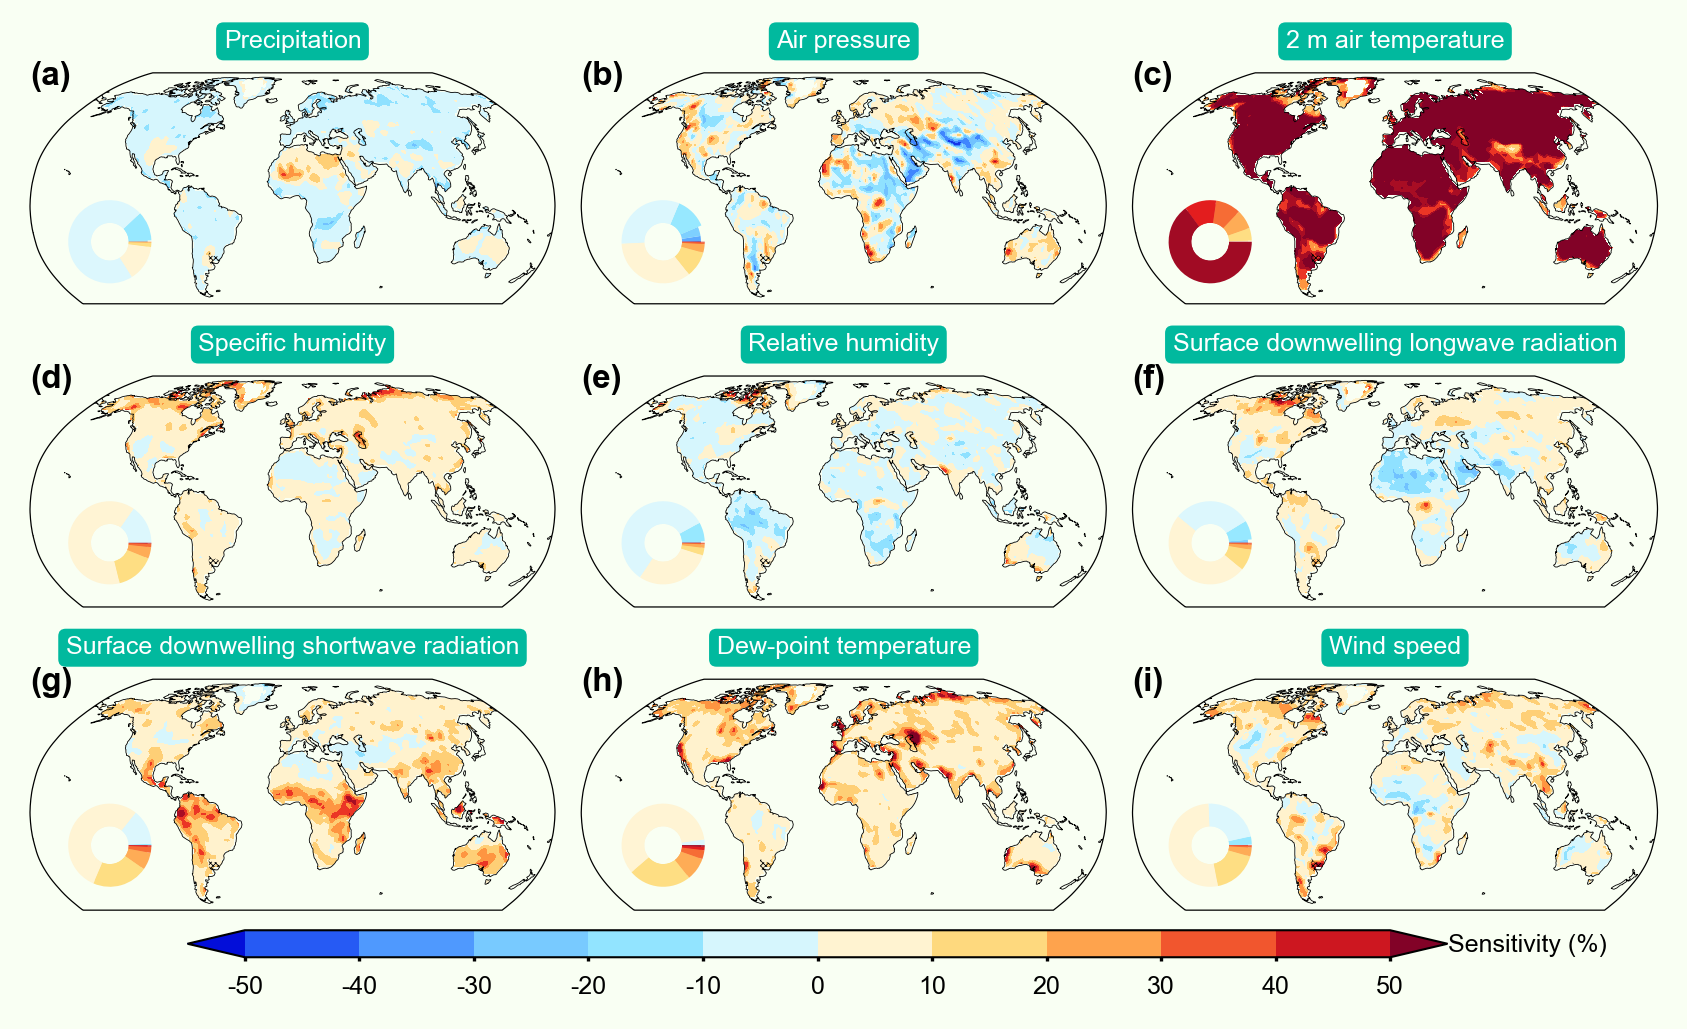

In [66]:
fig = plt.figure(figsize=(7,4.5), dpi=300)

mpl.rcParams['hatch.linewidth'] = 0.2
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":8})
projection = ccrs.Robinson()

ax1 = fig.add_subplot(3, 3, 1,
                      projection=projection)

lon, lat, array = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\pr_ssp126.tif")
R2 = rioxarray.open_rasterio(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\R_square_ssp126.tif")

draw(ax1, 'Precipitation', lon, lat, array, vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.55, 0.1), cmap=newcmap, number="(a)", p_value=R2[0])
ax111 = plt.axes([0.128, 0.645, 0.07, 0.07])
draw_proportion_chart(ax111, array, [-3, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 3], np.arange(-0.6, 0.65, 0.1), newcmap)
# gdf = gpd.read_file(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\Climate Reference regions\IPCC-WGI-reference-regions-v4_shapefile\IPCC-WGI-reference-regions-v4_land.shp")
# draw_vectors(ax1, gdf, projection, "Acronym")

ax2 = fig.add_subplot(3, 3, 2,
                      projection=projection)

lon, lat, array = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\ps_ssp126.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax2, 'Air pressure', lon, lat, array, vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.55, 0.1), cmap=newcmap, number="(b)", p_value=R2[0])

ax122 = plt.axes([0.3915, 0.645, 0.07, 0.07])
draw_proportion_chart(ax122, array, [-3, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 3], np.arange(-0.6, 0.65, 0.1), newcmap)
# gdf = gpd.read_file(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\Climate Reference regions\IPCC-WGI-reference-regions-v4_shapefile\IPCC-WGI-reference-regions-v4_land.shp")
# draw_vectors(ax1, gdf, projection, "Acronym")

ax3 = fig.add_subplot(3, 3, 3,
                      projection=projection)

lon, lat, array = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\tas_ssp126.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax3, '2 m air temperature', lon, lat, array, vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.55, 0.1), cmap=newcmap, number="(c)", p_value=R2[0])

ax123 = plt.axes([0.652, 0.645, 0.07, 0.07])
draw_proportion_chart(ax123, array, [-3, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 3], np.arange(-0.6, 0.65, 0.1), newcmap)

ax4 = fig.add_subplot(3, 3, 4,
                      projection=projection)

lon, lat, array = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\Q_ssp126.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax4, 'Specific humidity', lon, lat, array, vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.55, 0.1), cmap=newcmap, number="(d)", p_value=R2[0])

ax124 = plt.axes([0.128, 0.422, 0.07, 0.07])
draw_proportion_chart(ax124, array, [-3, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 3], np.arange(-0.6, 0.65, 0.1), newcmap)

ax5 = fig.add_subplot(3, 3, 5,
                      projection=projection)

lon, lat, array = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\RH_ssp126.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax5, 'Relative humidity', lon, lat, array, vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.55, 0.1), cmap=newcmap, number="(e)", p_value=R2[0])

ax125 = plt.axes([0.3915, 0.422, 0.07, 0.07])
draw_proportion_chart(ax125, array, [-3, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 3], np.arange(-0.6, 0.65, 0.1), newcmap)

ax6 = fig.add_subplot(3, 3, 6,
                      projection=projection)

lon, lat, array = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\rlds_ssp126.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax6, 'Surface downwelling longwave radiation', lon, lat, array, vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.55, 0.1), cmap=newcmap, number="(f)", p_value=R2[0])

ax126 = plt.axes([0.652, 0.422, 0.07, 0.07])
draw_proportion_chart(ax126, array, [-3, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 3], np.arange(-0.6, 0.65, 0.1), newcmap)

ax7 = fig.add_subplot(3, 3, 7,
                      projection=projection)

lon, lat, array = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\rsds_ssp126.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax7, 'Surface downwelling shortwave radiation', lon, lat, array, vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.55, 0.1), cmap=newcmap, number="(g)", p_value=R2[0])

ax127 = plt.axes([0.128, 0.198, 0.07, 0.07])
draw_proportion_chart(ax127, array, [-3, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 3], np.arange(-0.6, 0.65, 0.1), newcmap)

ax8 = fig.add_subplot(3, 3, 8,
                      projection=projection)

lon, lat, array = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\tdew_ssp126.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax8, 'Dew-point temperature', lon, lat, array, vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.55, 0.1), cmap=newcmap, number="(h)", p_value=R2[0])

ax128 = plt.axes([0.3915, 0.198, 0.07, 0.07])
draw_proportion_chart(ax128, array, [-3, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 3], np.arange(-0.6, 0.65, 0.1), newcmap)
fig.subplots_adjust(hspace=-0.3, wspace=0.05)

ax9 = fig.add_subplot(3, 3, 9,
                      projection=projection)

lon, lat, array = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled\ssp126\wind_ssp126.tif")
# p_value = rioxarray.open_rasterio(r"G:\SPEI_calculation\corr\p_value_era5.tif")
draw(ax9, 'Wind speed', lon, lat, array, vmin=-0.5, vmax=0.5, levels=np.arange(-0.5, 0.55, 0.1), cmap=newcmap, number="(i)", p_value=R2[0])

ax129 = plt.axes([0.652, 0.198, 0.07, 0.07])
draw_proportion_chart(ax129, array, [-3, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 3], np.arange(-0.6, 0.65, 0.1), newcmap)
fig.subplots_adjust(hspace=-0.3, wspace=0.05)
ax999 = plt.axes([0.2, 0.15, 0.6, 0.02])

cmap1 = newcmap
bounds = np.arange(-0.5, 0.55, 0.1)
norm1 = mpl.colors.BoundaryNorm(bounds, cmap1.N, extend='both')
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm1, cmap=cmap1), cax=ax999, orientation="horizontal", ticks=np.arange(-0.5, 0.55, 0.1), extend="both")
cbar.ax.set_xticklabels(['-50', '-40', "-30", "-20", "-10", "0", "10", "20", "30", "40", "50"], fontsize=6)
cbar.ax.tick_params(size=1)
cbar.outline.set_linewidth(0.5)
ax999.text(
        1.05, 0.2, "Sensitivity (%)",
        fontsize=6,
        transform = ax999.transAxes
    )
fig.patch.set_facecolor('#F9FFF3')
ax1.set_facecolor('#F9FFF3')
ax2.set_facecolor('#F9FFF3')
ax3.set_facecolor('#F9FFF3')
ax4.set_facecolor('#F9FFF3')
ax5.set_facecolor('#F9FFF3')
ax6.set_facecolor('#F9FFF3')
ax7.set_facecolor('#F9FFF3')
ax8.set_facecolor('#F9FFF3')
ax9.set_facecolor('#F9FFF3')
#heatmap here


# plt.tight_layout()
plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\CDHW_sens_CMIP6_ssp126.jpg", bbox_inches="tight", dpi=600)

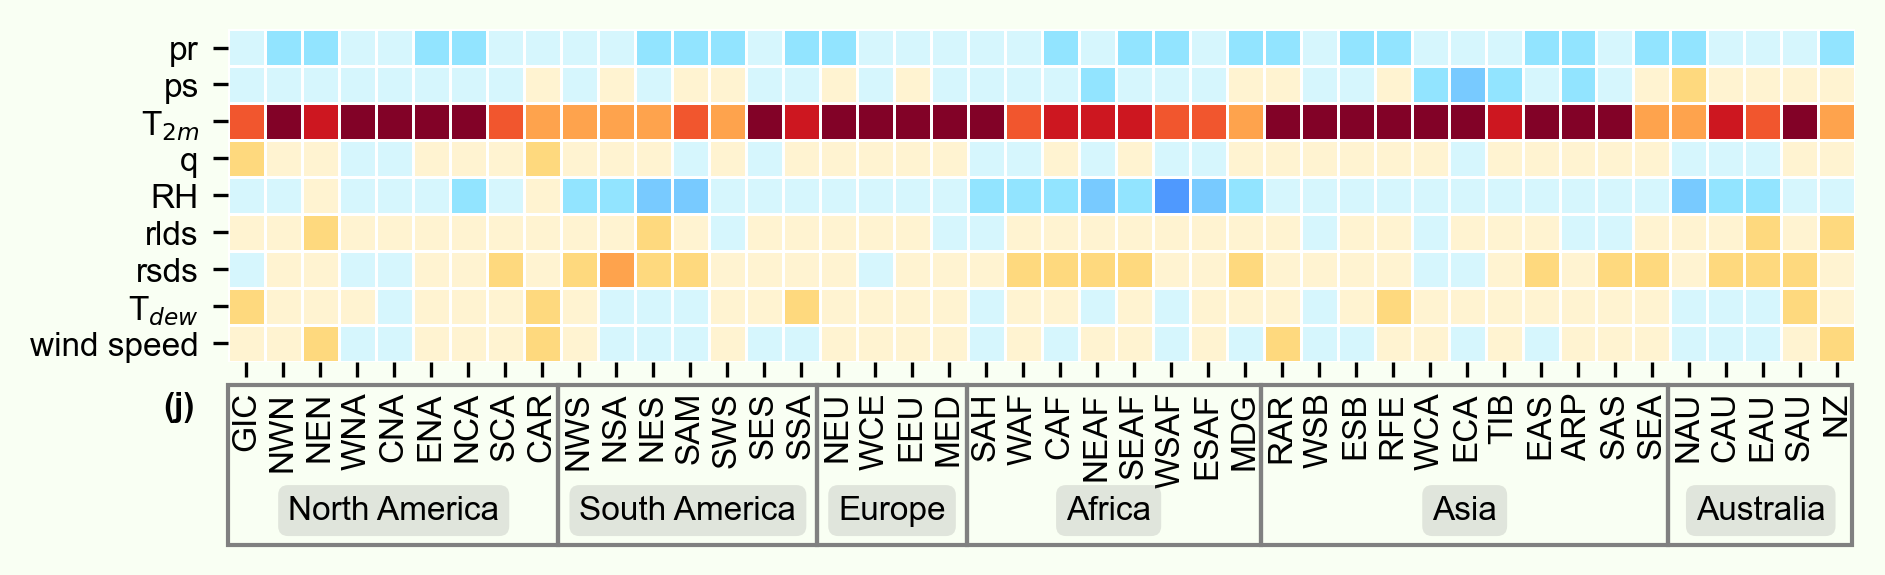

In [56]:
import matplotlib.patches as patches
import seaborn as sb
from matplotlib.colors import BoundaryNorm
mpl.rcParams['hatch.linewidth'] = 0.2
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":8})
fig = plt.figure(figsize=(7,2), dpi=300)
# plot heatmap

ax1 = fig.add_subplot(1, 1, 1)
fig.set_facecolor('#F9FFF3')
ax1.set_facecolor('#F9FFF3')
data_fig = pd.read_excel(r"F:\CMIP6_eco\CDHW\sensitivities\zonal_stats\ssp126.xlsx").iloc[:, 1:]
data_fig.index = ["pr", "ps", "T$_{2m}$", "q", "RH", "rlds", "rsds", "T$_{dew}$", "wind speed"]
cmap1 = mpl.cm.RdBu_r
bounds = np.arange(-0.5, 0.55, 0.1)
norm1 = mpl.colors.BoundaryNorm(bounds, cmap1.N, extend='both')
sb.heatmap(data_fig,  cmap=newcmap, vmin=-0.5, vmax=0.5, norm=norm1, square=True,
           linewidth=0.3, cbar=False)
ax1.text(-0.04, -0.16, "(j)", fontsize=8, fontweight="bold", transform=ax1.transAxes)
# NA
rect = patches.Rectangle((0.0, -0.55), 0.203, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# SA
rect = patches.Rectangle((0.203, -0.55), 0.159, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# EU
rect = patches.Rectangle((0.362, -0.55), 0.092, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# AF
rect = patches.Rectangle((0.454, -0.55), 0.181, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# AS
rect = patches.Rectangle((0.635, -0.55), 0.25, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

# AU
rect = patches.Rectangle((0.885, -0.55), 0.113, 0.48, fill=False, color="gray", linewidth=1, zorder=10, transform=ax1.transAxes)
fig.add_artist(rect)

props = dict(boxstyle='round', facecolor='gray', alpha=0.2, edgecolor="none")
ax1.text(0.037, -0.4, "North America", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.216, -0.4, "South America", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.375, -0.4, "Europe", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.515, -0.4, "Africa", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.74, -0.4, "Asia", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)
ax1.text(0.902, -0.4, "Australia", transform=ax1.transAxes, fontsize=8, verticalalignment='top', bbox=props)

plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\sens_ssp126_heatmap.jpg", bbox_inches="tight", dpi=300)

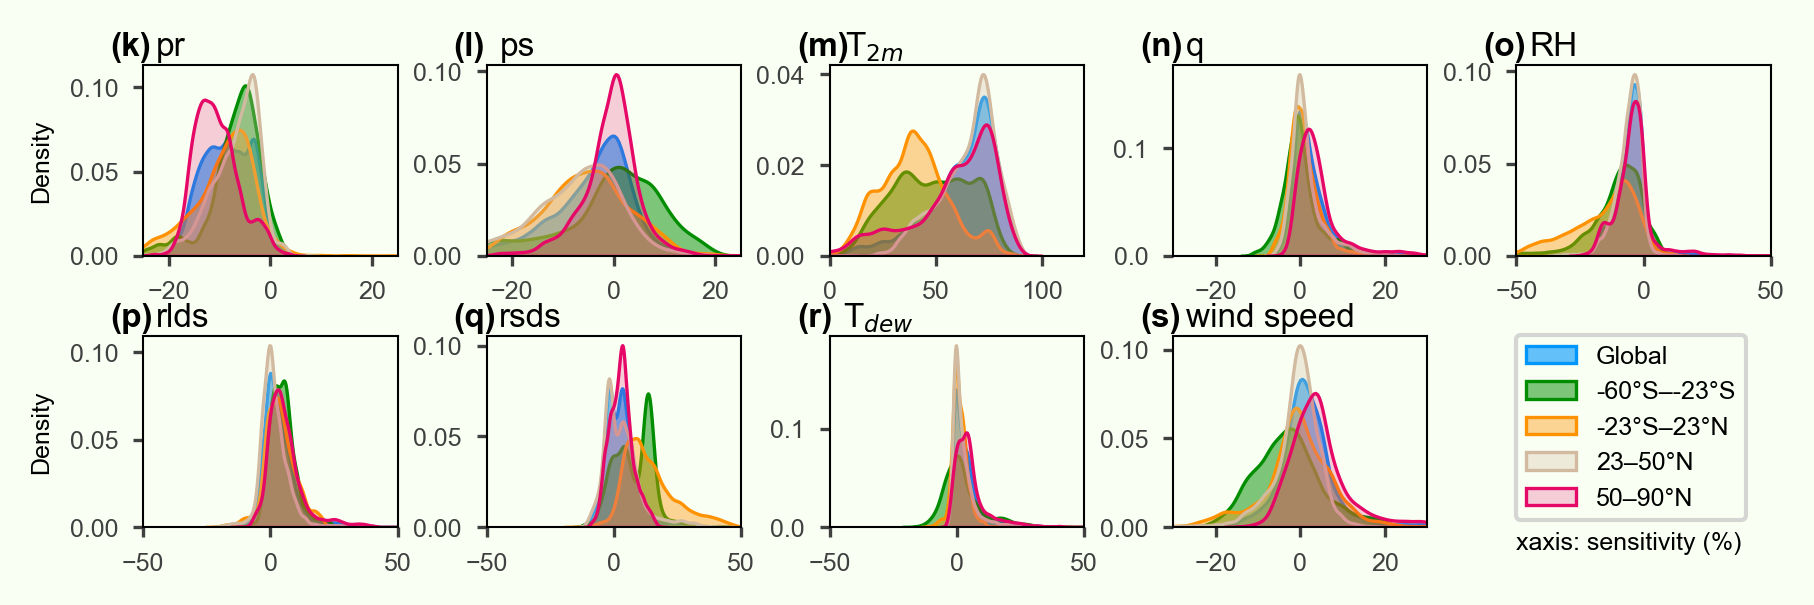

In [57]:
#aggregate variables in different area
import seaborn as sb
from matplotlib.colors import BoundaryNorm
mpl.rcParams['hatch.linewidth'] = 0.2
plt.rcParams["font.sans-serif"] = "Arial"
# plt.rcParams["font.weight"] = "bold"
# plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams.update({"font.size":6})
fig = plt.figure(figsize=(7,2), dpi=300)
ax1 = fig.add_subplot(2, 5, 1)
lon, lat, pr_global = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj\ssp126\pr_ssp126.tif")
lon, lat, pr_bot = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-60,-23_pr_ssp126.tif")
lon, lat, pr_botmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-23,23_pr_ssp126.tif")
lon, lat, pr_topmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\23,50_pr_ssp126.tif")
lon, lat, pr_top = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\50,90_pr_ssp126.tif")

pr_global = pr_global.reshape(-1)*100
pr_bot = pr_bot.reshape(-1)*100
pr_botmid = pr_botmid.reshape(-1)*100
pr_topmid = pr_topmid.reshape(-1)*100
pr_top = pr_top.reshape(-1)*100

sb.kdeplot(pr_global[~np.isnan(pr_global)],fill=True, color="#0196FC", label="Global", alpha=.6, linewidth=0.8,ax=ax1)
sb.kdeplot(pr_bot[~np.isnan(pr_bot)],fill=True, color="#008D00", label="-60°S–-23°S", alpha=.5, linewidth=0.8,ax=ax1)
sb.kdeplot(pr_botmid[~np.isnan(pr_botmid)],fill=True, color="#FF9202", label="-23°S–23°N", alpha=.4, linewidth=0.8,ax=ax1)
sb.kdeplot(pr_topmid[~np.isnan(pr_topmid)],fill=True, color="#D2BAA0", label="23–50°N", alpha=.3, linewidth=0.8,ax=ax1)
sb.kdeplot(pr_top[~np.isnan(pr_top)],fill=True, color="#E50867", label="50–90°N", alpha=.2, linewidth=0.8,ax=ax1)

ax2 = fig.add_subplot(2, 5, 2)
#snowfall
lon, lat, pr_global = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj\ssp126\ps_ssp126.tif")
lon, lat, pr_bot = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-60,-23_ps_ssp126.tif")
lon, lat, pr_botmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-23,23_ps_ssp126.tif")
lon, lat, pr_topmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\23,50_ps_ssp126.tif")
lon, lat, pr_top = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\50,90_ps_ssp126.tif")

pr_global = pr_global.reshape(-1)*100
pr_bot = pr_bot.reshape(-1)*100
pr_botmid = pr_botmid.reshape(-1)*100
pr_topmid = pr_topmid.reshape(-1)*100
pr_top = pr_top.reshape(-1)*100

sb.kdeplot(pr_global[~np.isnan(pr_global)],fill=True, color="#0196FC", label="Global", alpha=.6, linewidth=0.8, ax=ax2)
sb.kdeplot(pr_bot[~np.isnan(pr_bot)],fill=True, color="#008D00", label="-60°S–-23°S", alpha=.5, linewidth=0.8,ax=ax2)
sb.kdeplot(pr_botmid[~np.isnan(pr_botmid)],fill=True, color="#FF9202", label="-23°S–23°N", alpha=.4, linewidth=0.8,ax=ax2)
sb.kdeplot(pr_topmid[~np.isnan(pr_topmid)],fill=True, color="#D2BAA0", label="23–50°N", alpha=.3, linewidth=0.8, ax=ax2)
sb.kdeplot(pr_top[~np.isnan(pr_top)],fill=True, color="#E50867", label="50–90°N", alpha=.2, linewidth=0.8,ax=ax2)

ax3 = fig.add_subplot(2, 5, 3)
#tas
lon, lat, pr_global = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj\ssp126\tas_ssp126.tif")
lon, lat, pr_bot = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-60,-23_tas_ssp126.tif")
lon, lat, pr_botmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-23,23_tas_ssp126.tif")
lon, lat, pr_topmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\23,50_tas_ssp126.tif")
lon, lat, pr_top = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\50,90_tas_ssp126.tif")

pr_global = pr_global.reshape(-1)*100
pr_bot = pr_bot.reshape(-1)*100
pr_botmid = pr_botmid.reshape(-1)*100
pr_topmid = pr_topmid.reshape(-1)*100
pr_top = pr_top.reshape(-1)*100

sb.kdeplot(pr_global[~np.isnan(pr_global)],fill=True, color="#0196FC", label="Global", alpha=.6,linewidth=0.8, ax=ax3)
sb.kdeplot(pr_bot[~np.isnan(pr_bot)],fill=True, color="#008D00", label="-60°S–-23°S", alpha=.5,linewidth=0.8, ax=ax3)
sb.kdeplot(pr_botmid[~np.isnan(pr_botmid)],fill=True, color="#FF9202", label="-23°S–23°N", alpha=.4,linewidth=0.8, ax=ax3)
sb.kdeplot(pr_topmid[~np.isnan(pr_topmid)],fill=True, color="#D2BAA0", label="23–50°N", alpha=.3,linewidth=0.8, ax=ax3)
sb.kdeplot(pr_top[~np.isnan(pr_top)],fill=True, color="#E50867", label="50–90°N", alpha=.2,linewidth=0.8, ax=ax3)
ax4 = fig.add_subplot(2, 5, 4)

#q
lon, lat, pr_global = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj\ssp126\Q_ssp126.tif")
lon, lat, pr_bot = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-60,-23_Q_ssp126.tif")
lon, lat, pr_botmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-23,23_Q_ssp126.tif")
lon, lat, pr_topmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\23,50_Q_ssp126.tif")
lon, lat, pr_top = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\50,90_Q_ssp126.tif")

pr_global = pr_global.reshape(-1)*100
pr_bot = pr_bot.reshape(-1)*100
pr_botmid = pr_botmid.reshape(-1)*100
pr_topmid = pr_topmid.reshape(-1)*100
pr_top = pr_top.reshape(-1)*100

sb.kdeplot(pr_global[~np.isnan(pr_global)],fill=True, color="#0196FC", label="Global", alpha=.6,linewidth=0.8, ax=ax4)
sb.kdeplot(pr_bot[~np.isnan(pr_bot)],fill=True, color="#008D00", label="-60°S–-23°S", alpha=.5,linewidth=0.8, ax=ax4)
sb.kdeplot(pr_botmid[~np.isnan(pr_botmid)],fill=True, color="#FF9202", label="-23°S–23°N", alpha=.4,linewidth=0.8, ax=ax4)
sb.kdeplot(pr_topmid[~np.isnan(pr_topmid)],fill=True, color="#D2BAA0", label="23–50°N", alpha=.3,linewidth=0.8, ax=ax4)
sb.kdeplot(pr_top[~np.isnan(pr_top)],fill=True, color="#E50867", label="50–90°N", alpha=.2,linewidth=0.8, ax=ax4)

ax5 = fig.add_subplot(2, 5, 5)

#RH
lon, lat, pr_global = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj\ssp126\RH_ssp126.tif")
lon, lat, pr_bot = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-60,-23_RH_ssp126.tif")
lon, lat, pr_botmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-23,23_RH_ssp126.tif")
lon, lat, pr_topmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\23,50_RH_ssp126.tif")
lon, lat, pr_top = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\50,90_RH_ssp126.tif")

pr_global = pr_global.reshape(-1)*100
pr_bot = pr_bot.reshape(-1)*100
pr_botmid = pr_botmid.reshape(-1)*100
pr_topmid = pr_topmid.reshape(-1)*100
pr_top = pr_top.reshape(-1)*100

sb.kdeplot(pr_global[~np.isnan(pr_global)],fill=True, color="#0196FC", label="Global", alpha=.6,linewidth=0.8, ax=ax5)
sb.kdeplot(pr_bot[~np.isnan(pr_bot)],fill=True, color="#008D00", label="-60°S–-23°S", alpha=.5, linewidth=0.8, ax=ax5)
sb.kdeplot(pr_botmid[~np.isnan(pr_botmid)],fill=True, color="#FF9202", label="-23°S–23°N", alpha=.4,linewidth=0.8, ax=ax5)
sb.kdeplot(pr_topmid[~np.isnan(pr_topmid)],fill=True, color="#D2BAA0", label="23–50°N", alpha=.3,linewidth=0.8, ax=ax5)
sb.kdeplot(pr_top[~np.isnan(pr_top)],fill=True, color="#E50867", label="50–90°N", alpha=.2,linewidth=0.8, ax=ax5)

ax6 = fig.add_subplot(2, 5, 6)

#rlds
lon, lat, pr_global = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj\ssp126\rlds_ssp126.tif")
lon, lat, pr_bot = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-60,-23_rlds_ssp126.tif")
lon, lat, pr_botmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-23,23_rlds_ssp126.tif")
lon, lat, pr_topmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\23,50_rlds_ssp126.tif")
lon, lat, pr_top = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\50,90_rlds_ssp126.tif")

pr_global = pr_global.reshape(-1)*100
pr_bot = pr_bot.reshape(-1)*100
pr_botmid = pr_botmid.reshape(-1)*100
pr_topmid = pr_topmid.reshape(-1)*100
pr_top = pr_top.reshape(-1)*100

sb.kdeplot(pr_global[~np.isnan(pr_global)],fill=True, color="#0196FC", label="Global", alpha=.6,linewidth=0.8, ax=ax6)
sb.kdeplot(pr_bot[~np.isnan(pr_bot)],fill=True, color="#008D00", label="-60°S–-23°S", alpha=.5,linewidth=0.8, ax=ax6)
sb.kdeplot(pr_botmid[~np.isnan(pr_botmid)],fill=True, color="#FF9202", label="-23°S–23°N", alpha=.4,linewidth=0.8, ax=ax6)
sb.kdeplot(pr_topmid[~np.isnan(pr_topmid)],fill=True, color="#D2BAA0", label="23–50°N", alpha=.3,linewidth=0.8, ax=ax6)
sb.kdeplot(pr_top[~np.isnan(pr_top)],fill=True, color="#E50867", label="50–90°N", alpha=.2,linewidth=0.8, ax=ax6)

ax7 = fig.add_subplot(2, 5, 7)
#snowfall
lon, lat, pr_global = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj\ssp126\rsds_ssp126.tif")
lon, lat, pr_bot = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-60,-23_rsds_ssp126.tif")
lon, lat, pr_botmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-23,23_rsds_ssp126.tif")
lon, lat, pr_topmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\23,50_rsds_ssp126.tif")
lon, lat, pr_top = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\50,90_rsds_ssp126.tif")

pr_global = pr_global.reshape(-1)*100
pr_bot = pr_bot.reshape(-1)*100
pr_botmid = pr_botmid.reshape(-1)*100
pr_topmid = pr_topmid.reshape(-1)*100
pr_top = pr_top.reshape(-1)*100

sb.kdeplot(pr_global[~np.isnan(pr_global)],fill=True, color="#0196FC", label="Global", alpha=.6, linewidth=0.8,ax=ax7)
sb.kdeplot(pr_bot[~np.isnan(pr_bot)],fill=True, color="#008D00", label="-60°S–-23°S", alpha=.5,linewidth=0.8, ax=ax7)
sb.kdeplot(pr_botmid[~np.isnan(pr_botmid)],fill=True, color="#FF9202", label="-23°S–23°N", alpha=.4,linewidth=0.8, ax=ax7)
sb.kdeplot(pr_topmid[~np.isnan(pr_topmid)],fill=True, color="#D2BAA0", label="23–50°N", alpha=.3,linewidth=0.8, ax=ax7)
sb.kdeplot(pr_top[~np.isnan(pr_top)],fill=True, color="#E50867", label="50–90°N", alpha=.2,linewidth=0.8, ax=ax7)

ax8 = fig.add_subplot(2, 5, 8)

#dew-point
lon, lat, pr_global = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj\ssp126\tdew_ssp126.tif")
lon, lat, pr_bot = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-60,-23_tdew_ssp126.tif")
lon, lat, pr_botmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-23,23_tdew_ssp126.tif")
lon, lat, pr_topmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\23,50_tdew_ssp126.tif")
lon, lat, pr_top = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\50,90_tdew_ssp126.tif")

pr_global = pr_global.reshape(-1)*100
pr_bot = pr_bot.reshape(-1)*100
pr_botmid = pr_botmid.reshape(-1)*100
pr_topmid = pr_topmid.reshape(-1)*100
pr_top = pr_top.reshape(-1)*100

sb.kdeplot(pr_global[~np.isnan(pr_global)],fill=True, color="#0196FC", label="Global", alpha=.6, linewidth=0.8,ax=ax8)
sb.kdeplot(pr_bot[~np.isnan(pr_bot)],fill=True, color="#008D00", label="-60°S–-23°S", alpha=.5,linewidth=0.8, ax=ax8)
sb.kdeplot(pr_botmid[~np.isnan(pr_botmid)],fill=True, color="#FF9202", label="-23°S–23°N", alpha=.4,linewidth=0.8, ax=ax8)
sb.kdeplot(pr_topmid[~np.isnan(pr_topmid)],fill=True, color="#D2BAA0", label="23–50°N", alpha=.3,linewidth=0.8, ax=ax8)
sb.kdeplot(pr_top[~np.isnan(pr_top)],fill=True, color="#E50867", label="50–90°N", alpha=.2, linewidth=0.8,ax=ax8)

ax9 = fig.add_subplot(2, 5, 9)

#snowfall
lon, lat, pr_global = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj\ssp126\wind_ssp126.tif")
lon, lat, pr_bot = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-60,-23_wind_ssp126.tif")
lon, lat, pr_botmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\-23,23_wind_ssp126.tif")
lon, lat, pr_topmid = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\23,50_wind_ssp126.tif")
lon, lat, pr_top = get_geotiff_data(r"F:\CMIP6_eco\CDHW\sensitivities\sensitivities_merged_resampled_reproj_subregions\ssp126\50,90_wind_ssp126.tif")

pr_global = pr_global.reshape(-1)*100
pr_bot = pr_bot.reshape(-1)*100
pr_botmid = pr_botmid.reshape(-1)*100
pr_topmid = pr_topmid.reshape(-1)*100
pr_top = pr_top.reshape(-1)*100

sb.kdeplot(pr_global[~np.isnan(pr_global)],fill=True, color="#0196FC", label="Global", alpha=.6, linewidth=0.8,ax=ax9)
sb.kdeplot(pr_bot[~np.isnan(pr_bot)],fill=True, color="#008D00", label="-60°S–-23°S", alpha=.5, linewidth=0.8,ax=ax9)
sb.kdeplot(pr_botmid[~np.isnan(pr_botmid)],fill=True, color="#FF9202", label="-23°S–23°N", alpha=.4,linewidth=0.8, ax=ax9)
sb.kdeplot(pr_topmid[~np.isnan(pr_topmid)],fill=True, color="#D2BAA0", label="23–50°N", alpha=.3,linewidth=0.8, ax=ax9)
sb.kdeplot(pr_top[~np.isnan(pr_top)],fill=True, color="#E50867", label="50–90°N", alpha=.2, linewidth=0.8,ax=ax9)

ax1.text(
        -0.13, 1.05, "(k)",
        fontsize=8,
        fontweight="bold",
        transform = ax1.transAxes
    )
ax1.text(
        0.05, 1.05, "pr",
        fontsize=8,
        transform = ax1.transAxes
    )

ax2.text(
        -0.13, 1.05, "(l)",
        fontsize=8,
        fontweight="bold",
        transform = ax2.transAxes
    )
ax2.text(
        0.05, 1.05, "ps",
        fontsize=8,
        transform = ax2.transAxes
    )

ax3.text(
        -0.13, 1.05, "(m)",
        fontsize=8,
        fontweight="bold",
        transform = ax3.transAxes
    )
ax3.text(
        0.06, 1.05, "T$_{2m}$",
        fontsize=8,
        transform = ax3.transAxes
    )

ax4.text(
        -0.13, 1.05, "(n)",
        fontsize=8,
        fontweight="bold",
        transform = ax4.transAxes
    )
ax4.text(
        0.05, 1.05, "q",
        fontsize=8,
        transform = ax4.transAxes
    )

ax5.text(
        -0.13, 1.05, "(o)",
        fontsize=8,
        fontweight="bold",
        transform = ax5.transAxes
    )
ax5.text(
        0.05, 1.05, "RH",
        fontsize=8,
        transform = ax5.transAxes
    )

ax6.text(
        -0.13, 1.05, "(p)",
        fontsize=8,
        fontweight="bold",
        transform = ax6.transAxes
    )
ax6.text(
        0.05, 1.05, "rlds",
        fontsize=8,
        transform = ax6.transAxes
    )

ax7.text(
        -0.13, 1.05, "(q)",
        fontsize=8,
        fontweight="bold",
        transform = ax7.transAxes
    )
ax7.text(
        0.05, 1.05, "rsds",
        fontsize=8,
        transform = ax7.transAxes
    )

ax8.text(
        -0.13, 1.05, "(r)",
        fontsize=8,
        fontweight="bold",
        transform = ax8.transAxes
    )
ax8.text(
        0.05, 1.05, "T$_{dew}$",
        fontsize=8,
        transform = ax8.transAxes
    )
ax9.text(
        -0.13, 1.05, "(s)",
        fontsize=8,
        fontweight="bold",
        transform = ax9.transAxes
    )
ax9.text(
        0.05, 1.05, "wind speed",
        fontsize=8,
        transform = ax9.transAxes
    )
ax1.spines["bottom"].set_linewidth("0.5")
ax1.spines["left"].set_linewidth("0.5")
ax1.spines["top"].set_linewidth("0.5")
ax1.spines["right"].set_linewidth("0.5")
# ax7.margins(0, 0)

ax1.tick_params("x",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")



ax1.tick_params("y",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")

ax2.spines["bottom"].set_linewidth("0.5")
ax2.spines["left"].set_linewidth("0.5")
ax2.spines["top"].set_linewidth("0.5")
ax2.spines["right"].set_linewidth("0.5")
# ax7.margins(0, 0)

ax2.tick_params("x",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")



ax2.tick_params("y",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")

ax3.spines["bottom"].set_linewidth("0.5")
ax3.spines["left"].set_linewidth("0.5")
ax3.spines["top"].set_linewidth("0.5")
ax3.spines["right"].set_linewidth("0.5")
# ax7.margins(0, 0)

ax3.tick_params("x",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")



ax3.tick_params("y",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")

ax4.spines["bottom"].set_linewidth("0.5")
ax4.spines["left"].set_linewidth("0.5")
ax4.spines["top"].set_linewidth("0.5")
ax4.spines["right"].set_linewidth("0.5")
# ax7.margins(0, 0)

ax4.tick_params("x",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")



ax4.tick_params("y",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")

ax5.spines["bottom"].set_linewidth("0.5")
ax5.spines["left"].set_linewidth("0.5")
ax5.spines["top"].set_linewidth("0.5")
ax5.spines["right"].set_linewidth("0.5")
# ax7.margins(0, 0)

ax5.tick_params("x",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")



ax5.tick_params("y",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")

ax6.spines["bottom"].set_linewidth("0.5")
ax6.spines["left"].set_linewidth("0.5")
ax6.spines["top"].set_linewidth("0.5")
ax6.spines["right"].set_linewidth("0.5")
# ax7.margins(0, 0)

ax6.tick_params("x",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")



ax6.tick_params("y",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")

ax7.spines["bottom"].set_linewidth("0.5")
ax7.spines["left"].set_linewidth("0.5")
ax7.spines["top"].set_linewidth("0.5")
ax7.spines["right"].set_linewidth("0.5")
# ax7.margins(0, 0)

ax7.tick_params("x",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")



ax7.tick_params("y",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")
ax8.spines["bottom"].set_linewidth("0.5")
ax8.spines["left"].set_linewidth("0.5")
ax8.spines["top"].set_linewidth("0.5")
ax8.spines["right"].set_linewidth("0.5")
# ax7.margins(0, 0)

ax8.tick_params("x",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")



ax8.tick_params("y",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")
ax9.spines["bottom"].set_linewidth("0.5")
ax9.spines["left"].set_linewidth("0.5")
ax9.spines["top"].set_linewidth("0.5")
ax9.spines["right"].set_linewidth("0.5")
# ax7.margins(0, 0)

ax9.tick_params("x",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")



ax9.tick_params("y",which="major",
           length=2.5,width = 0.8,
           colors = "0.25")
ax2.set_ylabel("")
ax3.set_ylabel("")
ax4.set_ylabel("")
ax5.set_ylabel("")
ax7.set_ylabel("")
ax8.set_ylabel("")
ax9.set_ylabel("")
# ax8.set_xlabel("Sensitivity (%)")

ax9.legend(bbox_to_anchor=(2.3, 1.07), facecolor="#F9FFF3")
ax9.text(
        1.35, -0.12, "xaxis: sensitivity (%)",
        fontsize=6,
        transform = ax9.transAxes
    )
ax1.set_xlim(-25, 25)
ax2.set_xlim(-25, 25)
ax3.set_xlim(0, 120)
ax4.set_xlim(-30, 30)
ax5.set_xlim(-50, 50)
ax6.set_xlim(-50, 50)
ax7.set_xlim(-50, 50)
ax8.set_xlim(-50, 50)
ax9.set_xlim(-30, 30)
# ax6.set_ylim(0, 0.17)
# ax1.set_ylim(0, 0.17)
fig.patch.set_facecolor('#F9FFF3')
ax1.set_facecolor('#F9FFF3')
ax2.set_facecolor('#F9FFF3')
ax3.set_facecolor('#F9FFF3')
ax4.set_facecolor('#F9FFF3')
ax5.set_facecolor('#F9FFF3')
ax6.set_facecolor('#F9FFF3')
ax7.set_facecolor('#F9FFF3')
ax8.set_facecolor('#F9FFF3')
ax9.set_facecolor('#F9FFF3')
fig.subplots_adjust(hspace=0.42, wspace=0.35)
plt.savefig(r"E:\l3\创纪录极端复合干旱热浪事件影响生态系统生产力\figs\sens_ssp126_densities.jpg", bbox_inches="tight", dpi=300)